## Data Preprocessing

### Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [3]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating a data structure with 60 timesteps and 1 output

In [5]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building and Training the RNN

### Importing the Keras libraries and packages

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [8]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [9]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [10]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [11]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [12]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [13]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [14]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [15]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 7s 57ms/step - loss: 0.0498
Epoch 2/100
38/38 [==============================] - 2s 58ms/step - loss: 0.0072
Epoch 3/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0063
Epoch 4/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0056
Epoch 5/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0053
Epoch 6/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0050
Epoch 7/100
38/38 [==============================] - 3s 67ms/step - loss: 0.0044
Epoch 8/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 3s 79ms/step - loss: 0.0043
Epoch 10/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0038
Epoch 11/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0053
Epoch 13/100
38/38 [=====

38/38 [==============================] - 3s 79ms/step - loss: 0.0015


##  Making the predictions and visualising the results

### Getting the real stock price of 2017

In [20]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

In [21]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualising the results

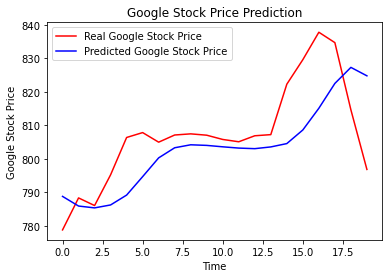

In [22]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [23]:
#Saving the model
regressor.save('regressor.hdf5')

In [26]:
#loading the model
import tensorflow as tf
loaded_model = tf.keras.models.load_model('regressor.hdf5')

In [27]:
#saving the scaled model
import pickle
filename = 'trained_model_scaled.sav'
pickle.dump(sc,open(filename,'wb'))

In [28]:
#Loading the scaled model
loaded_model_scaled = pickle.load(open('trained_model_scaled.sav','rb'))

In [30]:
def scaledata(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data.shape)
    return data_target_scaled, scaler

In [35]:
def futurePrediciton1D(curr_data,start="2021-02-1",end="2021-06-19"):
    '''
    '''
    x_data = curr_data[len(curr_data)-60:]
    curr_scaled = scaledata(x_data)[0]
    scaler = scaledata(curr_data)[1]
    
    #flatten into list
    x_data = list(curr_scaled.flatten())
    #convert into 3D
    x_data = np.array(x_data)
    x_data = x_data.reshape(1,len(x_data),1)
    #x_data = x_data[len(x_data)-120:]
    #x_data = tf.expand_dims(x_data,axis=1)
    
    #Predict
    nextDay = loaded_model.predict(x=x_data)
    nextDay = scaler.inverse_transform(nextDay.reshape(-1,1))

    nextDay = nextDay[-1][0]
    print("Prediction: {}".format(nextDay))
    
    #convert into dataframe again
    curr_data = pd.DataFrame(curr_data)
    curr_data.reset_index(inplace=True)
    open_cl = curr_data[['Open']]
    
    #concatenate new value
    open_cl.loc[len(open_cl.index)] = [nextDay]
    
    return open_cl


In [36]:
#Reading the training dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
dataset_train = pd.read_csv('D:/Users/dell1/Desktop/CERTIFICATES/Deep learning/RNN/Part+3+-+Recurrent+Neural+Networks/Part 3 - Recurrent Neural Networks/Google_Stock_Price_Train.csv')

In [37]:
train_set = dataset_train.iloc[:,1:2].values
dataset_train.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [38]:
futurePrediciton1D(dataset_train['Open'],start='2012-03-01', end='2017-01-01')

(60,)
(1258,)
Prediction: 609.7439575195312


C:\Users\dell1\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Open
0,325.250000
1,331.270000
2,329.830000
3,328.340000
4,322.040000
...,...
1254,790.680000
1255,793.700000
1256,783.330000
1257,782.750000


In [40]:
loaded_model = tf.keras.models.load_model('regressor.hdf5')

In [41]:
d = pd.read_csv('D:/Users/dell1/Downloads/GOOG.csv')

In [42]:
futurePrediciton1D(d['Open'],start='2012-03-01', end='2017-01-01')

(60,)
(250,)
Prediction: 113.88468170166016


C:\Users\dell1\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Open
0,107.514503
1,114.092003
2,116.008003
3,117.550003
4,118.650002
...,...
246,117.839996
247,117.959999
248,120.089996
249,121.099998
